In [ ]:
!unzip '/content/drive/MyDrive/ITH Project/Frames.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Frames/case_5329_frame_386_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_387_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_388_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_389_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_38_Viscoelastic.jpg  
  inflating: Frames/case_5329_frame_390_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_391_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_392_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_393_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_394_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_395_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_396_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_397_Phacoemulsification.jpg  
  inflating: Frames/case_5329_frame_398_Phacoemulsification.jpg  
  inflating: Frames/case_5329_fra

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/openai/guided-diffusion.git
%cd guided-diffusion
!pip install -e .


Cloning into 'guided-diffusion'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113 (from 1)
Receiving objects: 100% (113/113), 67.83 KiB | 13.56 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/guided-diffusion
Obtaining file:///content/guided-diffusion
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.7 MB/s eta 0:00:00
  Running setup.py develop for guided-diffusion


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

# Guided Diffusion Libraries
from guided_diffusion.unet import UNetModel
from guided_diffusion.gaussian_diffusion import GaussianDiffusion

In [ ]:
# Path to your data
data_path = r"/content/Frames"

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image size and batch size
image_size = 256
batch_size = 32

# Define phase-to-index mapping
phase_to_idx = {
    "Viscoelastic": 1,
    "Capsule_Polishing": 2,
    "Hydrodissection": 3,
    "Lens_Implantation": 4,
    "Lens_positioning": 5,
    "Viscoelastic_Suction": 6,
    "Capsulorhexis": 7,
    "Irrigation_Aspiration": 8,
    "Phacoemulsification": 9,
    "Anterior_Chamber_Flushing": 10,
    "Tonifying_Antibiotics": 11,
    "Incision": 12,
    "No_phase": 0  # For images without phase
}

# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
])

# Load Dataset from the CSV file
csv_file_path = "/content/image_labels.csv"  # Replace with the actual path to the CSV file
dataset = CataractDataset(csv_file=csv_file_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the UNet model
class UNetModel(nn.Module):
    def __init__(self, image_size, in_channels, model_channels, out_channels, num_res_blocks, attention_resolutions, num_classes):
        super(UNetModel, self).__init__()
        # Simple U-Net architecture
        self.conv1 = nn.Conv2d(in_channels, model_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(model_channels, model_channels, 3, padding=1)
        self.fc1 = nn.Linear(model_channels * image_size * image_size, num_classes)
        self.fc2 = nn.Linear(num_classes, out_channels * image_size * image_size)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x.view(x.size(0), 3, image_size, image_size)  # Reshape to image size

# Define the Gaussian Diffusion class
class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps=1000, loss_type='l1'):
        super(GaussianDiffusion, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.loss_type = loss_type
        self.beta_start = 0.0001
        self.beta_end = 0.02
        self.betas = torch.linspace(self.beta_start, self.beta_end, timesteps)
        self.alpha = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def forward(self, x0, t):
        # Ensure alpha_hat is on the same device as x0
        self.alpha_hat = self.alpha_hat.to(x0.device)

        batch_size = x0.size(0)  # Get batch size from input
        t = t.view(batch_size, 1, 1, 1)  # Reshape t to match the batch size

        # Ensure t is on the same device as alpha_hat
        t = t.to(self.alpha_hat.device)

        # Forward diffusion process: add noise to the image
        noise = torch.randn_like(x0).to(x0.device)  # Move noise to the same device as x0

        # Get alpha_hat and beta_hat for the given timestep
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t.squeeze()])
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t.squeeze()])

        x_t = sqrt_alpha_hat.view(-1, 1, 1, 1) * x0 + sqrt_one_minus_alpha_hat.view(-1, 1, 1, 1) * noise
        return x_t, noise


    def reverse_diffusion(self, x_t, t):
        return self.model(x_t)

    def loss(self, x0, x_t, t, model_output):
        if self.loss_type == 'l1':
            return torch.mean(torch.abs(x0 - model_output))
        elif self.loss_type == 'mse':
            return torch.mean((x0 - model_output) ** 2)
        else:
            raise ValueError("Unknown loss type")

# Training Loop
def train_model(model, diffusion, data_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(data_loader, leave=True)
        total_loss = 0
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # Forward pass through the diffusion model
            t = torch.randint(0, 1000, (images.size(0),), device=device)  # Random timestep
            x_t, noise = diffusion(images, t)
            model_output = diffusion.reverse_diffusion(x_t, t)

            # Calculate loss
            loss = diffusion.loss(images, x_t, t, model_output)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

# Sample generation function (reverse process)
def generate_samples(model, diffusion, num_samples=8):
    model.eval()
    with torch.no_grad():
        samples = torch.randn(num_samples, 3, image_size, image_size).to(device)  # Start from noise
        for t in range(999, -1, -1):  # Reverse the diffusion steps
            samples = diffusion.reverse_diffusion(samples, t)
    return samples

# Initialize model and diffusion
model = UNetModel(
    image_size=image_size,
    in_channels=3,
    model_channels=128,
    out_channels=3,
    num_res_blocks=2,
    attention_resolutions=[16, 8],  # Attention at these resolutions
    num_classes=12,  # Adjust based on your needs
).to(device)

# Initialize Gaussian Diffusion
diffusion = GaussianDiffusion(
    model=model,
    timesteps=1000,  # Number of diffusion steps
    loss_type='l1',  # Use L1 loss for sharper outputs
).to(device)

# Optimizer for training
learning_rate = 1e-4
optimizer = optim.Adam(diffusion.parameters(), lr=learning_rate)

# Train the model
train_model(model, diffusion, data_loader, optimizer, num_epochs=10)

# Generate some samples after training
generated_samples = generate_samples(model, diffusion, num_samples=8)
print("Sample generation completed")


Epoch [1/10]: 100%|██████████| 578/578 [06:27<00:00,  1.49it/s, loss=0.605]


Epoch 1, Loss: 0.8607220721904795


Epoch [2/10]: 100%|██████████| 578/578 [06:25<00:00,  1.50it/s, loss=0.569]


Epoch 2, Loss: 0.579399879622212


Epoch [3/10]: 100%|██████████| 578/578 [06:25<00:00,  1.50it/s, loss=0.505]


Epoch 3, Loss: 0.5366340827158166


Epoch [4/10]: 100%|██████████| 578/578 [06:26<00:00,  1.50it/s, loss=0.432]


Epoch 4, Loss: 0.4817984397539218


Epoch [5/10]: 100%|██████████| 578/578 [06:24<00:00,  1.50it/s, loss=0.3]


Epoch 5, Loss: 0.36974992682983304


Epoch [6/10]: 100%|██████████| 578/578 [06:26<00:00,  1.49it/s, loss=0.202]


Epoch 6, Loss: 0.2384008163502472


Epoch [7/10]: 100%|██████████| 578/578 [06:26<00:00,  1.50it/s, loss=0.167]


Epoch 7, Loss: 0.1758454512405148


Epoch [8/10]: 100%|██████████| 578/578 [06:24<00:00,  1.50it/s, loss=0.152]


Epoch 8, Loss: 0.1650010904226336


Epoch [9/10]: 100%|██████████| 578/578 [06:22<00:00,  1.51it/s, loss=0.151]


Epoch 9, Loss: 0.1644147283375057


Epoch [10/10]: 100%|██████████| 578/578 [06:21<00:00,  1.52it/s, loss=0.144]


Epoch 10, Loss: 0.16402566350455103
Sample generation completed


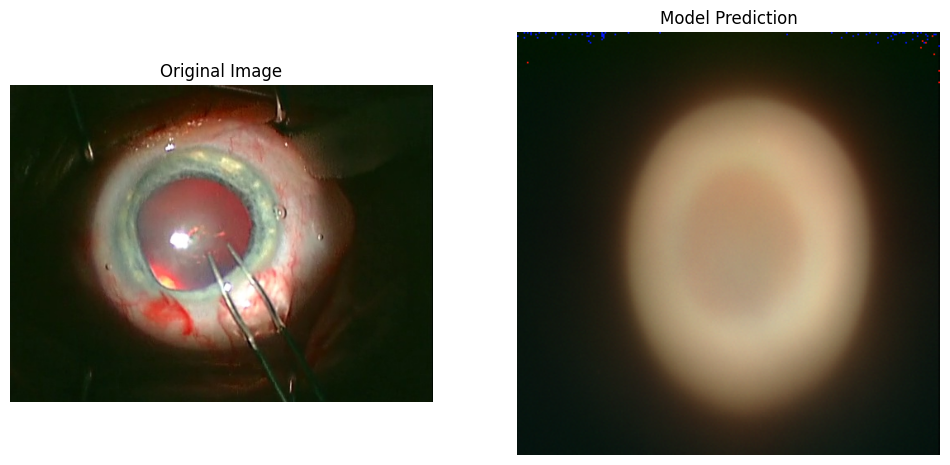

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Assuming `model`, `diffusion`, and `device` are already initialized

# Define the image size and transform
image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
])

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open the image and convert to RGB
    image = transform(image)  # Apply the transform
    image = image.unsqueeze(0)  # Add a batch dimension
    return image.to(device)

# Prediction function
def predict(image_path):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients during inference
        image = preprocess_image(image_path)  # Preprocess the image
        t = torch.randint(0, 1000, (image.size(0),), device=device)  # Random timestep
        x_t, _ = diffusion(image, t)  # Forward diffusion process
        model_output = diffusion.reverse_diffusion(x_t, t)  # Reverse diffusion (denoising)
        return model_output

# Function to visualize the output
def visualize_prediction(image_path):
    model_output = predict(image_path)  # Get the model's output

    # Convert tensor to image
    output_image = model_output.squeeze().cpu().numpy().transpose(1, 2, 0)
    output_image = (output_image * 0.5 + 0.5) * 255  # Denormalize and convert to 0-255
    output_image = output_image.astype('uint8')

    # Load the original image for comparison
    original_image = Image.open(image_path)

    # Display both the original image and the model's output
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(output_image)
    ax[1].set_title('Model Prediction')
    ax[1].axis('off')

    plt.show()

# Example usage: specify the image path and predict
image_path = '/content/Frames/case_4687_frame_100_Capsulorhexis.jpg'  # Replace with your image path
visualize_prediction(image_path)


In [ ]:
#################################################################################################

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image size and batch size
image_size = 256
batch_size = 16

# Define phase-to-index mapping
phase_to_idx = {
    "Viscoelastic": 1,
    "Capsule_Polishing": 2,
    "Hydrodissection": 3,
    "Lens_Implantation": 4,
    "Lens_positioning": 5,
    "Viscoelastic_Suction": 6,
    "Capsulorhexis": 7,
    "Irrigation_Aspiration": 8,
    "Phacoemulsification": 9,
    "Anterior_Chamber_Flushing": 10,
    "Tonifying_Antibiotics": 11,
    "Incision": 12,
    "No_phase": 0  # For images without phase
}

# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
])

# Load Dataset from the CSV file
csv_file_path = "/content/image_labels.csv"  # Replace with the actual path to the CSV file
dataset = CataractDataset(csv_file=csv_file_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the UNet model
class UNetModel(nn.Module):
    def __init__(self, image_size, in_channels, model_channels, out_channels, num_res_blocks, attention_resolutions, num_classes):
        super(UNetModel, self).__init__()
        # Simple U-Net architecture
        self.conv1 = nn.Conv2d(in_channels, model_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(model_channels, model_channels, 3, padding=1)
        self.fc1 = nn.Linear(model_channels * image_size * image_size, num_classes)
        self.fc2 = nn.Linear(num_classes, out_channels * image_size * image_size)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x.view(x.size(0), 3, image_size, image_size)  # Reshape to image size

# Define the Gaussian Diffusion class
class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps=1000, loss_type='l1'):
        super(GaussianDiffusion, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.loss_type = loss_type
        self.beta_start = 0.0001
        self.beta_end = 0.02
        self.betas = torch.linspace(self.beta_start, self.beta_end, timesteps)
        self.alpha = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def forward(self, x0, t):
        # Ensure alpha_hat is on the same device as x0
        self.alpha_hat = self.alpha_hat.to(x0.device)

        batch_size = x0.size(0)  # Get batch size from input
        t = t.view(batch_size, 1, 1, 1)  # Reshape t to match the batch size

        # Ensure t is on the same device as alpha_hat
        t = t.to(self.alpha_hat.device)

        # Forward diffusion process: add noise to the image
        noise = torch.randn_like(x0).to(x0.device)  # Move noise to the same device as x0

        # Get alpha_hat and beta_hat for the given timestep
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t.squeeze()])
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t.squeeze()])

        x_t = sqrt_alpha_hat.view(-1, 1, 1, 1) * x0 + sqrt_one_minus_alpha_hat.view(-1, 1, 1, 1) * noise
        return x_t, noise

    def reverse_diffusion(self, x_t, t):
        return self.model(x_t)

    def loss(self, x0, x_t, t, model_output):
        if self.loss_type == 'l1':
            return torch.mean(torch.abs(x0 - model_output))
        elif self.loss_type == 'mse':
            return torch.mean((x0 - model_output) ** 2)
        else:
            raise ValueError("Unknown loss type")

# Training Loop
def train_model(model, diffusion, data_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(data_loader, leave=True)
        total_loss = 0
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # Forward pass through the diffusion model
            t = torch.randint(0, 1000, (images.size(0),), device=device)  # Random timestep
            x_t, noise = diffusion(images, t)
            model_output = diffusion.reverse_diffusion(x_t, t)

            # Calculate loss
            loss = diffusion.loss(images, x_t, t, model_output)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

# Sample generation function (reverse process)
def generate_samples(model, diffusion, num_samples=8):
    model.eval()
    with torch.no_grad():
        samples = torch.randn(num_samples, 3, image_size, image_size).to(device)  # Start from noise
        for t in range(999, -1, -1):  # Reverse the diffusion steps
            samples = diffusion.reverse_diffusion(samples, t)
    return samples

# Initialize model and diffusion
model = UNetModel(
    image_size=image_size,
    in_channels=3,
    model_channels=128,
    out_channels=3,
    num_res_blocks=2,
    attention_resolutions=[16, 8],  # Attention at these resolutions
    num_classes=12,  # Adjust based on your needs
).to(device)

# Initialize Gaussian Diffusion
diffusion = GaussianDiffusion(
    model=model,
    timesteps=1000,  # Number of diffusion steps
    loss_type='l1',  # Use L1 loss for sharper outputs
).to(device)

# Optimizer for training
learning_rate = 1e-4
optimizer = optim.Adam(diffusion.parameters(), lr=learning_rate)

# Train the model
train_model(model, diffusion, data_loader, optimizer, num_epochs=10)

# Generate some samples after training
generated_samples = generate_samples(model, diffusion, num_samples=8)
print("Sample generation completed")


Epoch [1/10]: 100%|██████████| 1156/1156 [06:13<00:00,  3.09it/s, loss=0.559]


Epoch 1, Loss: 0.6885681301870973


Epoch [2/10]: 100%|██████████| 1156/1156 [06:14<00:00,  3.09it/s, loss=0.31]


Epoch 2, Loss: 0.46363318471760073


Epoch [3/10]: 100%|██████████| 1156/1156 [06:13<00:00,  3.10it/s, loss=0.172]


Epoch 3, Loss: 0.213584933687762


Epoch [4/10]: 100%|██████████| 1156/1156 [06:14<00:00,  3.09it/s, loss=0.16]


Epoch 4, Loss: 0.16540329903364182


Epoch [5/10]: 100%|██████████| 1156/1156 [05:56<00:00,  3.24it/s, loss=0.155]


Epoch 5, Loss: 0.16430693830018636


Epoch [6/10]: 100%|██████████| 1156/1156 [05:38<00:00,  3.42it/s, loss=0.164]


Epoch 6, Loss: 0.16402417728129556


Epoch [7/10]: 100%|██████████| 1156/1156 [05:38<00:00,  3.41it/s, loss=0.172]


Epoch 7, Loss: 0.1640574940605972


Epoch [8/10]: 100%|██████████| 1156/1156 [05:37<00:00,  3.43it/s, loss=0.182]


Epoch 8, Loss: 0.1640162980602893


Epoch [9/10]: 100%|██████████| 1156/1156 [05:37<00:00,  3.43it/s, loss=0.151]


Epoch 9, Loss: 0.163996852586323


Epoch [10/10]: 100%|██████████| 1156/1156 [05:36<00:00,  3.43it/s, loss=0.169]


Epoch 10, Loss: 0.1638904720493254
Sample generation completed


In [ ]:
# Save the model's state_dict (weights and architecture)
torch.save(model.state_dict(), '/content/ith.pth')


In [ ]:
# Save the entire diffusion model
torch.save(diffusion, '/content/diffusion_model.pth')


In [ ]:
print("iii")

iii


FINAL CODE

In [ ]:
import os
import csv

# Path to the folder containing the images
image_folder = "/content/Frames"

# Mapping phases to labels
phase_mapping = {
    0: "No phase", 1: "Viscoelastic", 2: "Capsule Pulishing", 3: "Hydrodissection",
    4: "Lens Implantation", 5: "Lens positioning", 6: "Viscoelastic_Suction",
    7: "Capsulorhexis", 8: "Irrigation_Aspiration", 9: "Phacoemulsification",
    10: "Anterior_Chamber Flushing", 11: "Tonifying_Antibiotics", 12: "Incision"
}

# Invert the phase_mapping for reverse lookup
phase_label_to_num = {v: k for k, v in phase_mapping.items()}

# Sort phase names by length in descending order to prioritize longer names
sorted_phases = sorted(phase_label_to_num.keys(), key=len, reverse=True)

# List to store rows for the CSV
rows = []

# Iterate through all files in the folder
for file_name in os.listdir(image_folder):
    if file_name.endswith(".jpg"):  # Check for image files
        matched_phase = None
        for phase in sorted_phases:
            if phase in file_name:
                matched_phase = phase
                break

        # If a phase is found, add it to the CSV data
        if matched_phase:
            numeric_label = phase_label_to_num[matched_phase]
            rows.append({"img": os.path.join(image_folder, file_name), "label": numeric_label})
        else:
            print(f"Phase not recognized, skipping: {file_name}")

# Write the rows to a CSV file
output_csv = "/content/image_labels.csv"
with open(output_csv, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["img", "label"])
    writer.writeheader()
    writer.writerows(rows)

print(f"CSV file created successfully: {output_csv}")


CSV file created successfully: /content/image_labels.csv


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants
image_size = 256
batch_size = 16
num_phases = 13  # Total number of surgery phases
num_epochs = 10
learning_rate = 1e-4
timesteps = 1000  # Number of diffusion timesteps

# CSV File Format: img (path to image), label (phase number)

# Define phase-to-index mapping
phase_mapping = {
    0: "No phase", 1: "Viscoelastic", 2: "Capsule Pulishing", 3: "Hydrodissection",
    4: "Lens Implantation", 5: "Lens positioning", 6: "Viscoelastic_Suction",
    7: "Capsulorhexis", 8: "Irrigation_Aspiration", 9: "Phacoemulsification",
    10: "Anterior_Chamber Flushing", 11: "Tonifying_Antibiotics", 12: "Incision"
}
# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load dataset
csv_file_path = "/content/image_labels.csv"  # Replace with the actual path to the CSV
dataset = CataractDataset(csv_file=csv_file_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a simple U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(image_size * image_size * 3, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x_flat = x.view(x.size(0), -1)
        logits = self.fc(x_flat)
        return logits

# Gaussian Diffusion Process
class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps=1000):
        super(GaussianDiffusion, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x0, t):
        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
        return x_t, noise

    def reverse_diffusion(self, x_t, t):
        return self.model(x_t)

# Initialize model and diffusion
model = UNet(num_classes=num_phases).to(device)
diffusion = GaussianDiffusion(model=model, timesteps=timesteps).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(diffusion.parameters(), lr=learning_rate)

# Training Loop
def train_model():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(data_loader, leave=True)
        total_loss = 0
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Sample random timesteps
            t = torch.randint(0, timesteps, (images.size(0),), device=device)

            # Forward diffusion
            x_t, noise = diffusion.forward_diffusion(images, t)

            # Reverse diffusion and classify
            logits = diffusion.reverse_diffusion(x_t, t)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

# Predict Phase
def predict_phase(image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Predict phase
    with torch.no_grad():
        logits = model(image)
        predicted_class = logits.argmax(dim=1).item()
        predicted_phase = phase_mapping[predicted_class]
    return predicted_phase

# Train the model
train_model()

# Example prediction
example_image = "/content/Frames/case_4687_frame_147_Hydrodissection.jpg"
predicted_phase = predict_phase(example_image)
print(f"Predicted Phase: {predicted_phase}")


Epoch [1/10]: 100%|██████████| 2448/2448 [12:09<00:00,  3.36it/s, loss=2.01]


Epoch 1, Loss: 2.2020356640998835


Epoch [2/10]: 100%|██████████| 2448/2448 [12:01<00:00,  3.39it/s, loss=2.01]


Epoch 2, Loss: 2.0266598113416845


Epoch [3/10]: 100%|██████████| 2448/2448 [12:01<00:00,  3.39it/s, loss=2.09]


Epoch 3, Loss: 1.9819179248381285


Epoch [4/10]: 100%|██████████| 2448/2448 [12:02<00:00,  3.39it/s, loss=2.4]


Epoch 4, Loss: 1.9237125744324883


Epoch [5/10]: 100%|██████████| 2448/2448 [12:02<00:00,  3.39it/s, loss=1.96]


Epoch 5, Loss: 1.863410982187667


Epoch [6/10]: 100%|██████████| 2448/2448 [12:02<00:00,  3.39it/s, loss=2.2]


Epoch 6, Loss: 1.7988636652677277


Epoch [7/10]: 100%|██████████| 2448/2448 [12:02<00:00,  3.39it/s, loss=1.85]


Epoch 7, Loss: 1.7490853840862615


Epoch [8/10]: 100%|██████████| 2448/2448 [12:01<00:00,  3.39it/s, loss=2.37]


Epoch 8, Loss: 1.7113843562653641


Epoch [9/10]: 100%|██████████| 2448/2448 [12:01<00:00,  3.39it/s, loss=2.09]


Epoch 9, Loss: 1.68218507245183


Epoch [10/10]: 100%|██████████| 2448/2448 [11:57<00:00,  3.41it/s, loss=1.3]


Epoch 10, Loss: 1.649572454076382
Predicted Phase: Hydrodissection


In [ ]:
def predict_phase(image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Predict phase
    with torch.no_grad():
        logits = model(image)
        predicted_class = logits.argmax(dim=1).item()
        predicted_phase = phase_mapping[predicted_class]
    return predicted_phase

# Train the model
# Example prediction
example_image = "/content/Frames/case_4687_frame_140_Hydrodissection.jpg"
predicted_phase = predict_phase(example_image)
print(f"Predicted Phase: {predicted_phase}")

Predicted Phase: Hydrodissection


In [ ]:
example_image = "/content/Frames/case_4687_frame_185_Phacoemulsification.jpg"
predicted_phase = predict_phase(example_image)
print(f"Predicted Phase: {predicted_phase}")

Predicted Phase: Phacoemulsification


In [ ]:
example_image = "/content/Frames/case_4687_frame_136_Capsulorhexis.jpg"
predicted_phase = predict_phase(example_image)
print(f"Predicted Phase: {predicted_phase}")

Predicted Phase: Capsulorhexis


In [ ]:
# Save the model after training to /content/
torch.save(model.state_dict(), "/content/cataract_surgery_phase_model.pth")
print("Model saved successfully at /content/cataract_surgery_phase_model.pth!")


Model saved successfully at /content/cataract_surgery_phase_model.pth!


In [ ]:
#reload model

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score

# Define constants
image_size = 256
batch_size = 16
num_phases = 13  # Total number of surgery phases

# CSV File Location
csv_file_path = "/content/image_labels.csv"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
dataset = CataractDataset(csv_file=csv_file_path, transform=transform)

# Split dataset into 10% for testing and 90% for training
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained model
model = UNet(num_classes=num_phases).to(device)
model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))
model.eval()  # Set the model to evaluation mode

# Function to test the model
def test_model():
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            logits = model(images)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Test the model on the 10% test dataset
test_model()


<ipython-input-19-a4c8edc6d402>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))


Test Accuracy: 80.03%


PREDICTION PHASE WISE

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants
image_size = 256
batch_size = 16
num_phases = 13  # Total number of surgery phases
num_epochs = 10
learning_rate = 1e-4
timesteps = 1000  # Number of diffusion timesteps

# CSV File Format: img (path to image), label (phase number)

# Define phase-to-index mapping
phase_mapping = {
    0: "No phase", 1: "Viscoelastic", 2: "Capsule Pulishing", 3: "Hydrodissection",
    4: "Lens Implantation", 5: "Lens positioning", 6: "Viscoelastic_Suction",
    7: "Capsulorhexis", 8: "Irrigation_Aspiration", 9: "Phacoemulsification",
    10: "Anterior_Chamber Flushing", 11: "Tonifying_Antibiotics", 12: "Incision"
}
# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load dataset
csv_file_path = "/content/image_labels.csv"  # Replace with the actual path to the CSV
dataset = CataractDataset(csv_file=csv_file_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a simple U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(image_size * image_size * 3, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x_flat = x.view(x.size(0), -1)
        logits = self.fc(x_flat)
        return logits

# Gaussian Diffusion Process
class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps=1000):
        super(GaussianDiffusion, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x0, t):
        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
        return x_t, noise

    def reverse_diffusion(self, x_t, t):
        return self.model(x_t)

# Initialize model and diffusion
model = UNet(num_classes=num_phases).to(device)
diffusion = GaussianDiffusion(model=model, timesteps=timesteps).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(diffusion.parameters(), lr=learning_rate)

# Training Loop
def train_model():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(data_loader, leave=True)
        total_loss = 0
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Sample random timesteps
            t = torch.randint(0, timesteps, (images.size(0),), device=device)

            # Forward diffusion
            x_t, noise = diffusion.forward_diffusion(images, t)

            # Reverse diffusion and classify
            logits = diffusion.reverse_diffusion(x_t, t)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

# Predict Phase
def predict_phase(image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Predict phase
    with torch.no_grad():
        logits = model(image)
        predicted_class = logits.argmax(dim=1).item()
        predicted_phase = phase_mapping[predicted_class]
    return predicted_phase


In [ ]:
# Load the model from /content/
model = UNet(num_classes=num_phases).to(device)
model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully from /content/cataract_surgery_phase_model.pth!")


Model loaded successfully from /content/cataract_surgery_phase_model.pth!


<ipython-input-24-b66ad9d6eabd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))


Wrong Metrics code so commented

In [1]:
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, random_split
# from torchvision import transforms
# from PIL import Image
# from sklearn.metrics import (accuracy_score, roc_auc_score,
#                              precision_score, recall_score, f1_score)
# import matplotlib.pyplot as plt
# import numpy as np

# # Define constants
# image_size = 256
# batch_size = 16
# num_phases = 13  # Total number of surgery phases

# # CSV File Location
# csv_file_path = "/content/image_labels.csv"

# # Phase mapping
# phase_mapping = {
#     0: "No phase", 1: "Viscoelastic", 2: "Capsule Polishing", 3: "Hydrodissection",
#     4: "Lens Implantation", 5: "Lens positioning", 6: "Viscoelastic Suction",
#     7: "Capsulorhexis", 8: "Irrigation Aspiration", 9: "Phacoemulsification",
#     10: "Anterior Chamber Flushing", 11: "Tonifying Antibiotics", 12: "Incision"
# }

# # Image transformations
# transform = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
# ])

# # Custom Dataset Class
# class CataractDataset(torch.utils.data.Dataset):
#     def __init__(self, csv_file, transform=None):
#         self.data = pd.read_csv(csv_file)
#         self.image_paths = self.data['img'].values
#         self.labels = self.data['label'].values
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         label = self.labels[idx]
#         image = Image.open(image_path).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # Load the dataset
# dataset = CataractDataset(csv_file=csv_file_path, transform=transform)

# # Split dataset into 25% for testing and 75% for training
# test_size = int(0.25 * len(dataset))
# train_size = len(dataset) - test_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # Create data loaders for test dataset
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Load the trained model
# model = UNet(num_classes=num_phases).to(device)
# model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))
# model.eval()  # Set the model to evaluation mode

# # Function to test the model and calculate metrics
# def evaluate_model():
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)

#             # Get model predictions
#             logits = model(images)
#             preds = logits.argmax(dim=1).cpu().numpy()
#             all_preds.extend(preds)
#             all_labels.extend(labels.cpu().numpy())

#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)

#     # Calculate metrics for each phase
#     phase_metrics = {}
#     for phase in range(num_phases):
#         phase_labels = (all_labels == phase).astype(int)
#         phase_preds = (all_preds == phase).astype(int)

#         precision = precision_score(phase_labels, phase_preds, zero_division=0)
#         recall = recall_score(phase_labels, phase_preds, zero_division=0)
#         f1 = f1_score(phase_labels, phase_preds, zero_division=0)
#         try:
#             auc = roc_auc_score(phase_labels, phase_preds)
#         except ValueError:
#             auc = 0.0

#         total_images = (all_labels == phase).sum()
#         phase_accuracy = (phase_preds == phase_labels).mean() if total_images > 0 else 0.0

#         phase_metrics[phase] = {
#             "Phase Name": phase_mapping.get(phase, "Unknown"),
#             "Precision": precision,
#             "Recall": recall,
#             "F1 Score": f1,
#             "AUC": auc,
#             "Accuracy": phase_accuracy,
#             "Total Images": total_images
#         }

#     # Calculate overall accuracy
#     overall_accuracy = accuracy_score(all_labels, all_preds)
#     print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

#     # Print metrics for each phase
#     for phase, metrics in phase_metrics.items():
#         print(f"Phase {phase} ({metrics['Phase Name']}):\n"
#               f"  Precision: {metrics['Precision']:.2f}\n"
#               f"  Recall: {metrics['Recall']:.2f}\n"
#               f"  F1 Score: {metrics['F1 Score']:.2f}\n"
#               f"  AUC: {metrics['AUC']:.2f}\n"
#               f"  Accuracy: {metrics['Accuracy']:.2f}\n"
#               f"  Total Images: {metrics['Total Images']}")

#     # Plot
#     phases = list(phase_metrics.keys())
#     precisions = [metrics["Precision"] for metrics in phase_metrics.values()]
#     recalls = [metrics["Recall"] for metrics in phase_metrics.values()]
#     f1_scores = [metrics["F1 Score"] for metrics in phase_metrics.values()]
#     aucs = [metrics["AUC"] for metrics in phase_metrics.values()]
#     accuracies = [metrics["Accuracy"] for metrics in phase_metrics.values()]

#     x = np.arange(len(phases))
#     width = 0.15

#     plt.figure(figsize=(14, 8))
#     plt.bar(x - 2 * width, precisions, width, label="Precision")
#     plt.bar(x - width, recalls, width, label="Recall")
#     plt.bar(x, f1_scores, width, label="F1 Score")
#     plt.bar(x + width, aucs, width, label="AUC")
#     plt.bar(x + 2 * width, accuracies, width, label="Accuracy")

#     plt.xlabel("Phase")
#     plt.ylabel("Score")
#     plt.title("Evaluation Metrics per Phase")
#     plt.xticks(x, [f"Phase {phase} ({phase_mapping.get(phase, 'Unknown')})" for phase in phases], rotation=45, ha="right")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Evaluate
# evaluate_model()


Final Prediction Phase Specific

<ipython-input-33-d6d9c1b6647f>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))


Evaluation Results Per Phase:
phase_3:
  Precision: 1.00
  Recall: 0.74
  F1 Score: 0.85
  AUC: 0.00
  Accuracy: 0.74
  Total Images: 2262
phase_6:
  Precision: 1.00
  Recall: 0.68
  F1 Score: 0.81
  AUC: 0.00
  Accuracy: 0.68
  Total Images: 3095
phase_7:
  Precision: 1.00
  Recall: 0.80
  F1 Score: 0.89
  AUC: 0.00
  Accuracy: 0.80
  Total Images: 3221
phase_1:
  Precision: 1.00
  Recall: 0.59
  F1 Score: 0.74
  AUC: 0.00
  Accuracy: 0.59
  Total Images: 1214
phase_10:
  Precision: 1.00
  Recall: 0.81
  F1 Score: 0.89
  AUC: 0.00
  Accuracy: 0.81
  Total Images: 1253
phase_9:
  Precision: 1.00
  Recall: 0.93
  F1 Score: 0.96
  AUC: 0.00
  Accuracy: 0.93
  Total Images: 10935
phase_0:
  Precision: 1.00
  Recall: 0.85
  F1 Score: 0.92
  AUC: 0.00
  Accuracy: 0.85
  Total Images: 6257
phase_12:
  Precision: 1.00
  Recall: 0.71
  F1 Score: 0.83
  AUC: 0.00
  Accuracy: 0.71
  Total Images: 857
phase_4:
  Precision: 1.00
  Recall: 0.56
  F1 Score: 0.72
  AUC: 0.00
  Accuracy: 0.56
  Total 

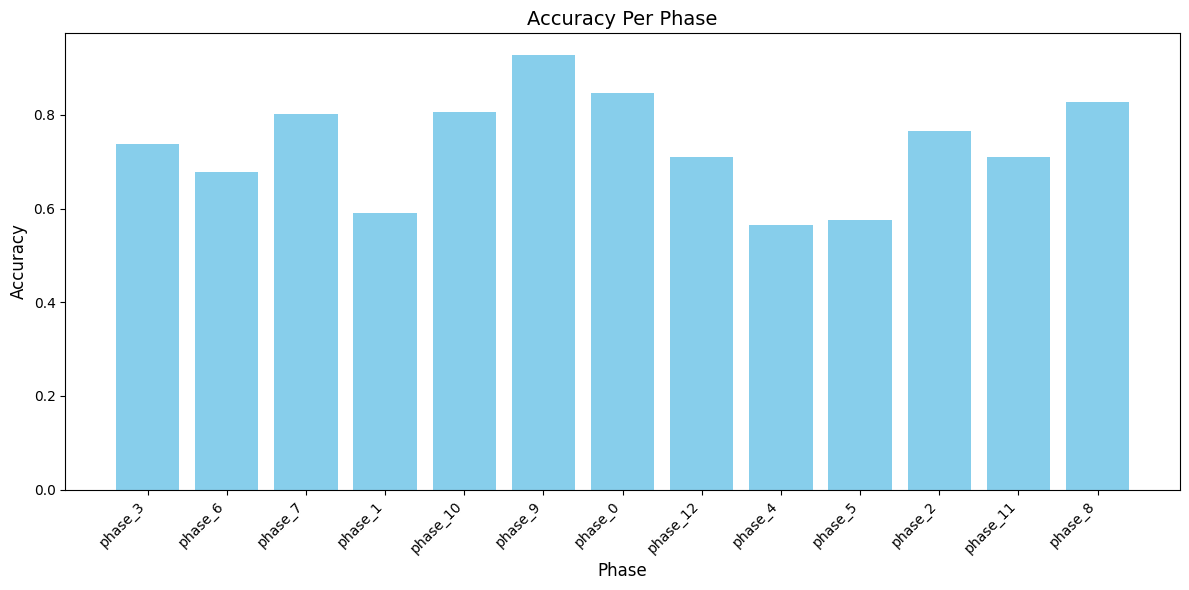

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define constants
image_size = 256
batch_size = 16

# Phase mapping
phase_mapping = {
    "Phase_0": "No phase", "Phase_1": "Viscoelastic", "Phase_2": "Capsule Polishing",
    "Phase_3": "Hydrodissection", "Phase_4": "Lens Implantation", "Phase_5": "Lens positioning",
    "Phase_6": "Viscoelastic Suction", "Phase_7": "Capsulorhexis", "Phase_8": "Irrigation Aspiration",
    "Phase_9": "Phacoemulsification", "Phase_10": "Anterior Chamber Flushing",
    "Phase_11": "Tonifying Antibiotics", "Phase_12": "Incision"
}

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the trained model
model = UNet(num_classes=len(phase_mapping)).to(device)
model.load_state_dict(torch.load("/content/cataract_surgery_phase_model.pth"))
model.eval()

# Evaluate the model for all CSVs
def evaluate_per_csv(csv_dir):
    phase_metrics = {}

    for csv_file in os.listdir(csv_dir):
        if not csv_file.endswith(".csv"):
            continue

        # Extract phase from the file name
        phase_name = os.path.splitext(csv_file)[0]
        phase_display_name = phase_mapping.get(phase_name, phase_name)

        # Load the dataset
        dataset = CataractDataset(csv_file=os.path.join(csv_dir, csv_file), transform=transform)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_preds, all_labels = [], []

        # Test the model
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Calculate metrics
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        try:
            auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        except ValueError:
            auc = 0.0
        accuracy = accuracy_score(all_labels, all_preds)

        phase_metrics[phase_name] = {
            "Phase Name": phase_display_name,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "Accuracy": accuracy,
            "Total Images": len(all_labels)
        }

    # Print and plot metrics
    print("Evaluation Results Per Phase:")
    for phase, metrics in phase_metrics.items():
        print(f"{metrics['Phase Name']}:\n"
              f"  Precision: {metrics['Precision']:.2f}\n"
              f"  Recall: {metrics['Recall']:.2f}\n"
              f"  F1 Score: {metrics['F1 Score']:.2f}\n"
              f"  AUC: {metrics['AUC']:.2f}\n"
              f"  Accuracy: {metrics['Accuracy']:.2f}\n"
              f"  Total Images: {metrics['Total Images']}")

    # Plot metrics
    phases = list(phase_metrics.keys())
    accuracies = [metrics["Accuracy"] for metrics in phase_metrics.values()]

    plt.figure(figsize=(12, 6))
    plt.bar(phases, accuracies, color='skyblue')
    plt.xlabel("Phase", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Accuracy Per Phase", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Directory containing phase-wise CSVs
csv_directory = "/content/phase_csvs"
evaluate_per_csv(csv_directory)


In [ ]:
data.shape

(39161, 2)

Weighted Loss added

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants
image_size = 256
batch_size = 16
num_phases = 13  # Total number of surgery phases
num_epochs = 10
learning_rate = 1e-4
timesteps = 1000  # Number of diffusion timesteps

# CSV File Format: img (path to image), label (phase number)

# Define phase-to-index mapping
phase_mapping = {
    0: "No phase", 1: "Viscoelastic", 2: "Capsule Pulishing", 3: "Hydrodissection",
    4: "Lens Implantation", 5: "Lens positioning", 6: "Viscoelastic_Suction",
    7: "Capsulorhexis", 8: "Irrigation_Aspiration", 9: "Phacoemulsification",
    10: "Anterior_Chamber Flushing", 11: "Tonifying_Antibiotics", 12: "Incision"
}

# Custom Dataset Class
class CataractDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['img'].values
        self.labels = self.data['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load dataset
csv_file_path = "/content/image_labels.csv"  # Replace with the actual path to the CSV
dataset = CataractDataset(csv_file=csv_file_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(dataset.labels),
    y=dataset.labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define a simple U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(image_size * image_size * 3, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x_flat = x.view(x.size(0), -1)
        logits = self.fc(x_flat)
        return logits

# Gaussian Diffusion Process
class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps=1000):
        super(GaussianDiffusion, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x0, t):
        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
        return x_t, noise

    def reverse_diffusion(self, x_t, t):
        return self.model(x_t)

# Initialize model and diffusion
model = UNet(num_classes=num_phases).to(device)
diffusion = GaussianDiffusion(model=model, timesteps=timesteps).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(diffusion.parameters(), lr=learning_rate)

# Training Loop
def train_model():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(data_loader, leave=True)
        total_loss = 0
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Sample random timesteps
            t = torch.randint(0, timesteps, (images.size(0),), device=device)

            # Forward diffusion
            x_t, noise = diffusion.forward_diffusion(images, t)

            # Reverse diffusion and classify
            logits = diffusion.reverse_diffusion(x_t, t)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

# Train the model
train_model()
